In [141]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import seaborn as sns
import matplotlib as mpl
import itertools

from sklearn.linear_model import LogisticRegression
from stop_words import get_stop_words
from sklearn.dummy import DummyClassifier
from scikitplot import classifier_factory
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, learning_curve, ShuffleSplit

%matplotlib inline

In [14]:
#lmtzr = WordNetLemmatizer()
tagged = nltk.pos_tag(word_tokenize('I ran rapidly'))
print(tagged)
print(word_tokenize('I ran rapidly'))

[('I', 'PRP'), ('ran', 'VBD'), ('rapidly', 'RB')]
['I', 'ran', 'rapidly']


In [70]:
def my_lemmatization(text):
    punct = '”“".,«»\\/*!:;—()\'-%`.?―[]...'
    lemmatizer = WordNetLemmatizer()
    tagged = nltk.pos_tag(word_tokenize(text.lower()))
    return [lemmatizer.lemmatize(element[0], get_wordnet_pos(element[1])) for element in tagged if element[0] not in punct]

In [50]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# в остальных случаях - анализ по дефолту (сущ)    

In [9]:
print(my_lemmatization('I am loving these leaves. I can do it!'))

['i', 'be', 'love', 'these', 'leaf', '.', 'i', 'can', 'do', 'it', '!']


In [10]:
print(word_tokenize('I am loving these leaves. I can do it!'))

['I', 'am', 'loving', 'these', 'leaves', '.', 'I', 'can', 'do', 'it', '!']


In [51]:
cues = pandas.read_csv('All-seasons.csv')
cues.head()
# сперва я в текстов редакторе заменила \n внутри колонки Line на ничего

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away."
1,10,1,Kyle,Going away? For how long?
2,10,1,Stan,Forever.
3,10,1,Chef,I'm sorry boys.
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."


## Проверим, сбалансирована ли выборка

In [33]:
new_table = cues.pivot_table(index='Character', values=['Line'], aggfunc='count')
new_table.sort_values(by=['Line'], ascending=False)

,Line
Character,
Cartman,9774
Stan,7680
Kyle,7099
Butters,2602
Randy,2467
Mr. Garrison,1002
Chef,917
Kenny,881
Sharon,862


Как видно из таблицы, персонажей в Южном парке очень много. Большинство из них не сказали в 10 сезонах больше пары реплик.
Я решила взять главных персонажей, то есть верхушку таблицы (первые четыре значения). Для этого нужно собрать новый датасет.

In [101]:
df = cues.loc[(cues['Character'] == 'Cartman') | (cues['Character'] == 'Stan') | (cues['Character'] == 'Kyle') | (cues['Character'] == 'Butters')].sample(frac=1).reset_index(drop=True)
print(df.head())
print(df.shape)
print(df['Character'].unique())

  Season Episode Character                                               Line
0     17       7   Cartman  You can't change his mind, Sir Kyle. Sony peop...
1      4       7   Cartman                  I swear I'm gonna kill you guys!!
2      7       5   Cartman  You have to get out of here! Jennifer Lopez is...
3      5       5      Stan                          Come on, Kenny, hurry up!
4      6       6      Stan                              Okay, let's try this.
(27155, 4)
['Cartman' 'Stan' 'Kyle' 'Butters']


In [95]:
df['Character'] = df['Character'].map({'Cartman': 0, 'Stan':1, 'Kyle': 2, 'Butters':3}).astype(int)
print(df['Character'].unique())

[0 1 2 3]


Теперь поделим его на тестовую и тренировочную выборки.

In [102]:
X_train, X_test, y_train, y_test = train_test_split(df['Line'], 
                                                    df['Character'], 
                                                    test_size=0.2)

In [71]:
freq = {}
for line in X_train:
    lemmas = my_lemmatization(line)
    for lemma in lemmas:
        if lemma not in freq:
            freq[lemma] = 1
        else:
            freq[lemma] += 1

In [72]:
for k in sorted(freq, key=freq.get, reverse=True):
    print(k + ': ' + str(freq[k]))
    

you: 8759
i: 8346
be: 7808
the: 6065
to: 5427
's: 5124
do: 4802
it: 4599
a: 4380
we: 3951
that: 3632
and: 3615
n't: 3591
what: 2723
have: 2633
get: 2450
of: 2360
this: 2106
my: 1961
on: 1898
in: 1870
're: 1781
go: 1767
all: 1734
me: 1728
just: 1661
'm: 1639
oh: 1615
no: 1597
dude: 1518
for: 1491
na: 1417
he: 1388
yeah: 1355
guy: 1313
know: 1222
your: 1202
but: 1184
not: 1175
they: 1168
with: 1149
so: 1146
come: 1101
can: 1073
well: 1061
now: 1046
out: 1029
gon: 1026
like: 1025
kyle: 1015
right: 1007
here: 955
there: 905
think: 903
up: 897
see: 860
cartman: 822
hey: 800
how: 789
about: 787
say: 783
u: 760
if: 759
look: 745
've: 740
make: 723
'll: 705
at: 698
okay: 694
our: 694
let: 686
ca: 684
butter: 655
want: 651
kenny: 637
uh: 631
people: 617
really: 613
tell: 589
time: 581
take: 581
one: 572
why: 530
god: 528
mom: 526
then: 524
good: 517
him: 513
who: 504
back: 487
dad: 487
``: 485
'': 484
need: 452
stan: 444
because: 429
from: 429
will: 421
thing: 418
mean: 417
his: 414
some: 397
w

Как мы видим, в верхушке частотного списка слова, которые обычно входят в список стоп-слов. Ругательств там нет. Поэтому не буду их убирать

In [77]:
stopwords = get_stop_words('en')

In [130]:
bow = CountVectorizer(tokenizer=my_lemmatization, stop_words=stopwords)
bowed_lines = bow.fit_transform(X_train)

In [131]:
X_finaltrain, X_validation, y_finaltrain, y_validation = train_test_split(bowed_lines, y_train, test_size=0.2)

In [132]:
print(X_finaltrain.shape, X_validation.shape, y_finaltrain.shape, y_validation.shape)

(17379, 10622) (4345, 10622) (17379,) (4345,)


In [136]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [133]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_finaltrain, y_finaltrain)
y_pred = rfc.predict(X_validation)
print(classification_report(y_validation, y_pred))

             precision    recall  f1-score   support

    Butters       0.55      0.24      0.33       425
    Cartman       0.56      0.56      0.56      1559
       Kyle       0.39      0.36      0.38      1148
       Stan       0.39      0.49      0.43      1213

avg / total       0.47      0.46      0.45      4345



Confusion matrix, without normalization
[[102 115  86 122]
 [ 31 878 262 388]
 [ 22 283 415 428]
 [ 29 300 294 590]]


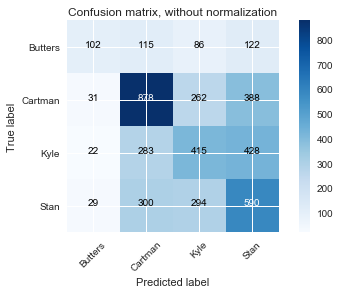

In [144]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_validation, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=rfc.classes_,
                      title='Confusion matrix, without normalization')
plt.show()

In [134]:
naive_model = MultinomialNB()
naive_model.fit(X_finaltrain, y_finaltrain)
y_pred_naive = naive_model.predict(X_validation)
print(classification_report(y_validation, y_pred_naive))

             precision    recall  f1-score   support

    Butters       0.68      0.28      0.39       425
    Cartman       0.49      0.70      0.58      1559
       Kyle       0.47      0.30      0.36      1148
       Stan       0.41      0.42      0.42      1213

avg / total       0.48      0.47      0.46      4345



Confusion matrix, without normalization
[[ 117  183   27   98]
 [  28 1086  152  293]
 [  13  454  339  342]
 [  13  488  197  515]]


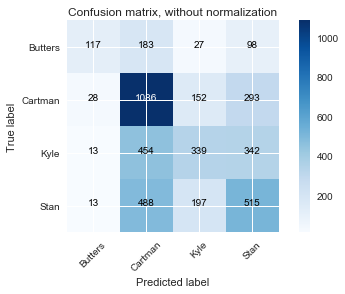

In [145]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_validation, y_pred_naive)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=naive_model.classes_,
                      title='Confusion matrix, without normalization')
plt.show()

In [135]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_finaltrain, y_finaltrain)
y_pred_log = logreg.predict(X_validation)
print(classification_report(y_validation, y_pred_log))

             precision    recall  f1-score   support

    Butters       0.41      0.47      0.44       425
    Cartman       0.61      0.57      0.59      1559
       Kyle       0.40      0.43      0.41      1148
       Stan       0.43      0.42      0.43      1213

avg / total       0.48      0.48      0.48      4345



Confusion matrix, without normalization
[[198  80  74  73]
 [119 885 275 280]
 [ 97 234 489 328]
 [ 71 258 371 513]]


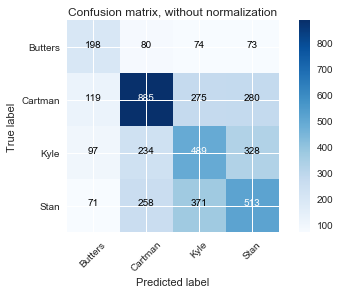

In [146]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_validation, y_pred_log)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=logreg.classes_,
                      title='Confusion matrix, without normalization')
plt.show()

Что-то результаты не очень высокие. Попробуем TfidfVectorizer. 

## Confusion Matrix. Анализ

Лучше всего распознаются реплики Картмана и Стэна (среди трех классификаторов). Довольно много реплик ошибочно отнесено к репликам Картмана. У этих двух персонажей больше всего реплик в датасете.

In [124]:
bow = TfidfVectorizer(tokenizer=my_lemmatization, stop_words=stopwords)
bowed = bow.fit_transform(X_train)

In [125]:
X_finaltrain, X_validation, y_finaltrain, y_validation = train_test_split(bowed, y_train, test_size=0.2)

In [126]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_finaltrain, y_finaltrain)
y_pred = rfc.predict(X_validation)
print(classification_report(y_validation, y_pred))

             precision    recall  f1-score   support

    Butters       0.58      0.20      0.29       450
    Cartman       0.51      0.67      0.58      1596
       Kyle       0.42      0.36      0.39      1092
       Stan       0.40      0.39      0.39      1207

avg / total       0.46      0.46      0.45      4345



In [127]:
naive_model = MultinomialNB()
naive_model.fit(X_finaltrain, y_finaltrain)
y_pred_naive = naive_model.predict(X_validation)
print(classification_report(y_validation, y_pred_naive))

             precision    recall  f1-score   support

    Butters       0.97      0.07      0.13       450
    Cartman       0.45      0.81      0.58      1596
       Kyle       0.47      0.21      0.29      1092
       Stan       0.42      0.35      0.38      1207

avg / total       0.50      0.45      0.41      4345



In [128]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_finaltrain, y_finaltrain)
y_pred_log = logreg.predict(X_validation)
print(classification_report(y_validation, y_pred_log))

             precision    recall  f1-score   support

    Butters       0.45      0.51      0.48       450
    Cartman       0.56      0.61      0.59      1596
       Kyle       0.42      0.39      0.40      1092
       Stan       0.43      0.39      0.41      1207

avg / total       0.48      0.48      0.48      4345



По ф-мере чуть получше для трех классификаторов сработал CountVectorizer(). Анализ confusion matrix для данных с применением CountVectorizer() выше.